# 0 - Imports

In [4]:
from datetime import datetime
from collections import Counter

# Data management
import pandas as pd

# Data preprocessing and trasformation (ETL)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, \
    FunctionTransformer, Binarizer, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml, load_iris, make_moons, make_classification


# Math and Stat modules
import numpy as np
from scipy.stats import sem
from random import choice

# Supervised Learning
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, \
    KFold, StratifiedKFold, RepeatedKFold, ShuffleSplit, StratifiedShuffleSplit, learning_curve, validation_curve
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, \
    precision_recall_curve, roc_curve, accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

# Unsupervised Learning

# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

# Network
import networkx as nx

In [5]:
from node2vec import Node2Vec

# 1 - Link Prediction

**Definition**

Given a social network denoted as $G=(V,E)$, where a timestamp is associated with each edge $e$, the subgraph $G[t,t']$ is defined as the set of edges whose timestamps fall between $t$ and $t'$. 

Given $G[t_{0}, t'_{0}]$, the task of link prediction involves returning a set of edges not present in $G[t_{0}, t'_{0}]$ but that could be present in $G[t_{1}, t'_{1}]$, where $t'_{0}<t_{1}$

In [ ]:
beers_temporal = nx.Graph()

# 2 - Recommendation System with Node2Vec

### 2.1 - Crate the graph to perform the recommendation system

In [21]:
beer_df = pd.read_csv("beer_reviews.csv")

# change the dtype to datetime
beer_df['review_time'] = pd.to_datetime(beer_df['review_time'], unit="s")

# rename some columns in a more handy way
beer_df = beer_df.rename(columns={'beer_beerid': 'beer_id', 'review_profilename':'user'})

# remove the null values
beer_df = beer_df.dropna()

# sub-sample keeping 2012 only
sub_beer_df = beer_df[beer_df['review_time'].dt.year == 2012].copy()
sub_beer_df.shape

(9343, 13)

In [22]:
# keep only profiles that reviewed more than one beer
users_reviews_count = sub_beer_df['user'].value_counts()
kept_profiles_only = users_reviews_count[users_reviews_count>1].index

sub_beer_df = sub_beer_df[sub_beer_df['user'].isin(kept_profiles_only)].copy()
sub_beer_df.shape

(8646, 13)

In [23]:
# Create an empty graph
user_beer_graph = nx.Graph()

# Add nodes for users and beers
user_beer_graph.add_nodes_from(sub_beer_df['user'], bipartite='user')
user_beer_graph.add_nodes_from(sub_beer_df['beer_name'], bipartite='beer')

# Add edges representing user-beer interactions
for _, row in sub_beer_df.iterrows():
    user_beer_graph.add_edge(row['user'], row['beer_name']) #, rating=row['beer_style'])  # Assuming 'rating' is an attribute in your dataset

nx.bipartite.is_bipartite(user_beer_graph)

True

### 2.2 - A brief introduction & intuitions

Link to the paper: https://arxiv.org/pdf/1607.00653.pdf

$\textcolor{red}{\textbf{Breadth-first Sampling (BFS)}}$ The neighborhood $N_{s}$ is restricted to nodes which are immediate neighbors of the source.
For example, in Figure 1 for a neighborhood of size k = 3, BFS samples nodes $s_{1}, s_{2}, s_{3}$.

$\textcolor{blue}{\textbf{Depth-first Sampling (DFS)}}$ The neighborhood consists of nodes sequentially sampled at increasing distances from the source node. In Figure 1, DFS samples $s_{4}, s_{5}, s_{6}$.

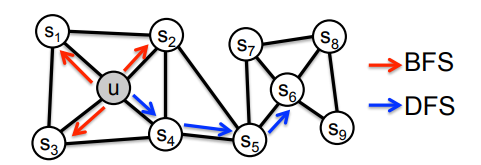

Under the homophily hypothesis, nodes that are highly interconnected and belong to similar network clusters or communities should be embedded closely together (e.g.,
nodes $s_{1}$ and $u$ in Figure 1 belong to the same network community). 

In contrast, under the structural equivalence hypothesis nodes that have similar structural roles in networks should be embedded closely together (e.g., nodes $u$ and $s_{6}$ in Figure 1 act as hubs of their corresponding communities).

**In-Out Parameter q** allows the search to differentiate between “inward” and “outward” nodes:
- If $\textcolor{red}{q>1}$, the random walk is biased towards nodes close to node $t$. Such walks obtain a local view of the underlying graph with respect to the start node in the walk and $\textcolor{red}{\text{approximate BFS behavior}}$.
- If $\textcolor{blue}{q<1}$, the walk is more inclined to visit nodes which are further away from the node $t$. Such behavior $\textcolor{blue}{\text{is reflective of DFS}}$ which encourages outward exploration. 

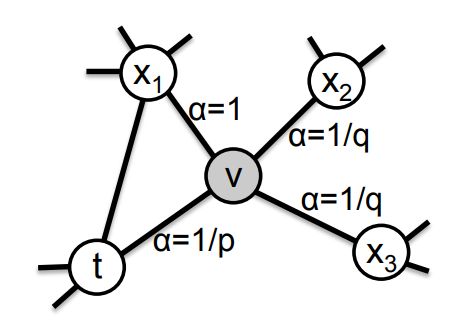

**Parameter p** controls the likelihood of immediately revisiting a node in the walk. 
 - Setting it to a $\textcolor{blue}{\text{high value}}$ (> max(q, 1)) ensures that we are less likely to sample an already visited node in the following two steps. This strategy $\textcolor{blue}{\text{encourages moderate exploration}}$. 
- On the other hand, $\textcolor{red}{\text{if p is low}}$ (< min(q, 1)), it would lead the walk to backtrack a step and this would $\textcolor{red}{\text{keep the walk “local”}}$ close to the starting node u.

### 2.3 - Depth First Search

In [28]:
# generate random walks
DFS = Node2Vec(user_beer_graph, dimensions=32, 
                    walk_length=80, num_walks=40,
                    p=2, q=0.7, workers=1)              # q<1 & p>max(0.7, 1) --> DFS

model = DFS.fit(window=10, min_count=2)

def recommend(user, num_recommendations=10):
    # Get the embeddings of the input user
    user_embedding = model.wv[str(user)]

    # Find beers that are most similar to the input user
    similar_beers = model.wv.most_similar([user_embedding], topn=num_recommendations+1)

    # Filter out the input user from the recommended list
    similar_beers = [(beer, similarity) for beer, similarity in similar_beers if beer != user]    

    # ensure that the suitable recommended beers haven't been reviewed yet
    already_reviewed = set(sub_beer_df[sub_beer_df['user']==user]['beer_name'])
    similar_beers = [(beer, similarity) for beer, similarity in similar_beers if beer not in already_reviewed]

    return similar_beers[:num_recommendations]

recommended_beers = recommend('Knapp85', num_recommendations=10)
print(recommended_beers)

Generating walks (CPU: 1): 100%|██████████| 40/40 [01:13<00:00,  1.83s/it]


[]


### 2.4 - Breadth First Search

In [26]:
# generate random walks
BFS = Node2Vec(user_beer_graph, dimensions=16, 
                    walk_length=12, num_walks=50,
                    p=2, q=0.7, workers=1)              # q>1 & p<min(1.3, 1) --> BFS

model = BFS.fit(window=10, min_count=2)

def recommend(user, num_recommendations=10):
    # Get the embeddings of the input user
    user_embedding = model.wv[str(user)]

    # Find beers that are most similar to the input user
    similar_beers = model.wv.most_similar([user_embedding], topn=num_recommendations+1)

    # Filter out the input user from the recommended list
    similar_beers = [(beer, similarity) for beer, similarity in similar_beers if beer != user]    

    # ensure that the suitable recommended beers haven't been reviewed yet
    already_reviewed = set(sub_beer_df[sub_beer_df['user']==user]['beer_name'])
    similar_beers = [(beer, similarity) for beer, similarity in similar_beers if beer not in already_reviewed]

    return similar_beers[:num_recommendations]

recommended_beers = recommend('gtermi', num_recommendations=10)
print(recommended_beers)

Computing transition probabilities: 100%|██████████| 5254/5254 [00:00<00:00, 7029.23it/s]


[('lmdengis', 0.8514260649681091)]
